In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from common import *
from competitions.dsb2017 import dsbconfig as comp;
import dicom
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from nbpapaya import Brain, clear_brain, Brain, Surface, Overlay
import SimpleITK as sitk
import csv
from tqdm import tqdm
import xml
from bs4 import BeautifulSoup

In [ ]:
PROJECT_PATH = os.path.join('/bigguy/data/luna')
DATA_PATH = os.path.join('/bigguy/data/luna/data')
META_PATH = os.path.join(PROJECT_PATH, 'csv')
EXTRACTED_IMG_PATH = os.path.join(PROJECT_PATH, 'extracted_imgs')
EXTRACTED_LABEL_PATH = os.path.join(PROJECT_PATH, 'extracted_labels')
ANNOTATIONS_PATH = os.path.join(META_PATH, 'annotations.csv')
LIDC_ANNO_PATH = os.path.join(META_PATH, 'lidc_annotations')
LUNA_NEG_CANDIDATES_PATH = os.path.join(META_PATH, 'luna_neg_candidates.csv')
MEAN_PIXEL_VALUE_NODULE = 41
SEGMENTER_IMG_SIZE = 320
TARGET_VOXEL_MM = 1.00
VOXEL_SPACING = [TARGET_VOXEL_MM, TARGET_VOXEL_MM, TARGET_VOXEL_MM]
subset_path = os.path.join(DATA_PATH, 'subset0')
fpaths = glob(subset_path+"/*.mhd")

In [ ]:
# LIDC
# https://wiki.cancerimagingarchive.net/download/attachments/3539039/LIDC_XML_Documentation_1_Jan_2009.doc?version=1&modificationDate=1319224566057&api=v2
"""
The LIDC used a two phase reading process. In the first phase, multiple readers (N=4 as of Jan 2006), read and annotated each case independently in a blinded fashion.  That is, they all read the same cases, but they the readings were done asynchronously and independently.  After the results of that first, blinded reading were complete, they were compiled and sent back out to the same readers so that they could see both their own markings as well as the markings from the other three readers.  Each reader then, again independently, read each case, this time with the benefit of information as to what other readers saw/marked, and then made a final decisions about the markings for that case.

3 step annotation process:
1) Blind read by 4 radiologists
2) Each radiologist showed the annotations of the others
3) Unblind read by 4 radiologists

IMAGES ONLY INCLUDE THE 2nd Unblinded Read

Interesting!!
Malignancy - Radiologist subjective assessment of likelihood of malignancy of this nodule, ASSUMING  60-year-old male smoker 

3 Types of Annotations:
1) Nodules >= 3mm diameter 
    - Complete outline (segmentation)
    - Include characteristics (e.g. malignancy)
2) Nodules < 3mm diameter 
    - Center of mass labeled (x,y,z)
    - Do not include characteristics
3) Non-Nodules > 3mm  diameter
    - Center of mass labeled (x,y,z)
    - Do not include characteristics

* Non-Nodules < 3mm were NOT marked! (might confuse the model)

Terms
-----
* Scan files = 158.xml, 162.xml..
* SeriesInstanceUid = Patient
* StudyInstanceUID = Scan 
* nodule id – a unique id for the nodule marked by this reader
* Nodule Contour ROI – this is the description of the complete three dimensional contour of the nodule (remembering that the radiologist was instructed to mark the first voxel outside the nodule)
* Inclusion – “True” means that the roi that follows is considered part of the nodule; “False” means that the roi that follows should be subtracted from the nodule.
* Locus – is unique to non-nodules (and is used in place of “edge map”) and indicates that the indicator point of the non-nodule is to follow:
<locus>				beginning of non-nodule description
<xCoord>215</xCoord>		x coordinate location of non-nodule
<yCoord>312</yCoord>		y coordinate location of non-nodule
</locus>				end of non-nodule description


<SeriesInstanceUid>1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102183795724852353824</SeriesInstanceUid>
<StudyInstanceUID>1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277323131167631068432</StudyInstanceUID>


* Nodules >= 3mm diameter 

 <unblindedReadNodule>
   <noduleID>6</noduleID>
   <characteristics>
    <subtlety>5</subtlety>
    <internalStructure>1</internalStructure>
    <calcification>4</calcification>
    <sphericity>3</sphericity>
    <margin>5</margin>
    <lobulation>2</lobulation>
    <spiculation>3</spiculation>
    <texture>5</texture>
    <malignancy>4</malignancy>
   </characteristics>
   
   ## ROIS are the same nodule on different slices
   <roi>
    <imageZposition>1616.5</imageZposition>
    <imageSOP_UID>1.3.6.1.4.1.14519.5.2.1.6279.6001.315628943944666928553332863367</imageSOP_UID>
    <inclusion>TRUE</inclusion>
    <edgeMap><xCoord>339</xCoord><yCoord>240</yCoord></edgeMap>
    <edgeMap><xCoord>338</xCoord><yCoord>241</yCoord></edgeMap>
    <edgeMap><xCoord>337</xCoord><yCoord>242</yCoord></edgeMap>
   </roi>
   <roi>
    <imageZposition>1616.5</imageZposition>
    <imageSOP_UID>1.3.6.1.4.1.14519.5.2.1.6279.6001.315628943944666928553332863367</imageSOP_UID>
    <inclusion>TRUE</inclusion>
    <edgeMap><xCoord>339</xCoord><yCoord>240</yCoord></edgeMap>
    <edgeMap><xCoord>338</xCoord><yCoord>241</yCoord></edgeMap>
    <edgeMap><xCoord>337</xCoord><yCoord>242</yCoord></edgeMap>
   </roi>
 </unblindedReadNodule>
 
 
 
* Nodules < 3mm diameter 

  <unblindedReadNodule>
   <noduleID>5</noduleID>
   <roi>
    <imageZposition>1631.5</imageZposition>
    <imageSOP_UID>1.3.6.1.4.1.14519.5.2.1.6279.6001.349696112719071080933041621585</imageSOP_UID>
    <inclusion>TRUE</inclusion>
    <edgeMap><xCoord>197</xCoord><yCoord>321</yCoord></edgeMap>
   </roi>
  </unblindedReadNodule>



* Non-Nodules > 3mm  diameter:

  <nonNodule>
   <nonNoduleID>2058</nonNoduleID>
   <imageZposition>1628.5</imageZposition>
   <imageSOP_UID>1.3.6.1.4.1.14519.5.2.1.6279.6001.216194661683946632889617404306</imageSOP_UID>
   <locus>
    <xCoord>199</xCoord><yCoord>320</yCoord>
   </locus>
  </nonNodule>
""";


In [ ]:
def find_mhd_file(patient_id):
    for subject_no in range(10):
        src_dir = os.path.join(
            DATA_PATH, "subset" + str(subject_no)) + "/"
        for src_path in glob(src_dir + "*.mhd"):
            if patient_id in src_path:
                return src_path
    return None

def load_lidc_xml(xml_path, agreement_threshold=0, only_patient=None, save_nodules=False):
    """
    Writes 2 CSV files with nodule and non-nodule annotations
        - nodules >= 3mm
        - non-nodules
    Nodule annotations include: id, z, y, x, diameter, malignancy
    Coords and Diameter are stored as percent of image size
    Diameter is calculated as the max of x and y
        - We reduce irregularly shaped nodules into circles (boxes)
    Optionally include only nodules with radiologist agreement
    Ignores nodules < 3mm
    """
    pos_lines = []
    neg_lines = []
    extended_lines = []
    
    # Each LIDC xml file represents a read of a single 3D CT Scan (multiple slices)
    with open(xml_path, 'r') as xml_file:
        markup = xml_file.read()
    xml = BeautifulSoup(markup, features="xml")
    
    # Catch corrupt files
    if xml.LidcReadMessage is None:
        return None, None, None
    
    patient_id = xml.LidcReadMessage.ResponseHeader.SeriesInstanceUid.text

    # Option to filter for single patient
    if only_patient is not None:
        if only_patient != patient_id:
            return None, None, None

    # Load the CT Scan image by patient_id
    src_path = find_mhd_file(patient_id)
    if src_path is None:
        return None, None, None
    
    # Load the CT Scan with SimpleITK
    # This a 3D volume containing multiple 2D slices
    itk_img = sitk.ReadImage(src_path)
    
    # Convert to Numpy (z, 512, 512)
    img_array = sitk.GetArrayFromImage(itk_img)
    
    # z,y,x (height before width)
    num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
    
    # Needed to calculate offet and normalize
    # Follow-up on this..
    origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
    spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
    
    # 1.00 is a hyperparameter 
#     # Rescale so that every voxel represents an volume of 1x1x1 mm
#     # Needed to ensure consistency across scans
#     rescale = spacing / 1.00 #1x1x1

    # Up to 4 per scan, one per radiologist
    reading_sessions = xml.LidcReadMessage.find_all("readingSession")
    
    # A reading session is all slices in CT Scan read by one radiologist
    for reading_session in reading_sessions:
        
        # Get the list of nodules (since up to 4 reads, many will identify the same nodule)
        nodules = reading_session.find_all("unblindedReadNodule")

        # Includes both >= 3 (characteristics and outline) and <3 (just the centroid)
        for nodule in nodules:
            nodule_id = nodule.noduleID.text # e.g. 1823
            
            # Same nodule appears in multiple slices (3D)
            rois = nodule.find_all("roi")
            
            # To create the annotations we're going to find the edges
            # of the outline, calculate the center
            # then use the diameter to segment?
            x_min = y_min = z_min = 999999
            x_max = y_max = z_max = -999999
            
            # Skip nodules < 3mm (they only have 1 point (x,y) marked on 1 slicet (the center))
            if len(rois) < 2:
                continue

            # For each slice in nodule >= 3mm
            for roi in rois:
                
                # If Z is < ZMin or >ZMax, update
                z_pos = float(roi.imageZposition.text)
                z_min = min(z_min, z_pos)
                z_max = max(z_max, z_pos)
                
                # Edge maps are single points (x,y) in the outline
                edge_maps = roi.find_all("edgeMap")
                for edge_map in edge_maps:
                    x = int(edge_map.xCoord.text)
                    y = int(edge_map.yCoord.text)
                    x_min = min(x_min, x)
                    y_min = min(y_min, y)
                    x_max = max(x_max, x)
                    y_max = max(y_max, y)
                
                # Catching an edge case 
                # where annotations are crap
                if x_max == x_min:
                    continue
                if y_max == y_min:
                    continue

            # Calculate the diameter + center
            x_diameter = x_max - x_min
            x_center = x_min + x_diameter / 2
            y_diameter = y_max - y_min
            y_center = y_min + y_diameter / 2
            z_diameter = z_max - z_min
            z_center = z_min + z_diameter / 2
            
            # Adjust the center based on origin + spacing
            # Since each scan taken by different machine there
            # is variation..
            z_center -= origin[2]
            z_center /= spacing[2]

            # Calculate the percent (normalized location) of the center
            # with respect to the image size
            # Why?
            # Why are y and x backwards? I thought x would come first....
            x_center_perc = round(x_center / img_array.shape[2], 4)
            y_center_perc = round(y_center / img_array.shape[1], 4)
            z_center_perc = round(z_center / img_array.shape[0], 4)
            
            # Set the diameter to the max of x, y
            # This simplifies the annotation by ignoring ovals 
            # and non-circular nodules..
            diameter = max(x_diameter , y_diameter)
            
            # What percentage is the nodule size of the whole image..
            diameter_perc = round(max(x_diameter / img_array.shape[2], y_diameter / img_array.shape[1]), 4)

            # Skip nodules with important missing fields
            if nodule.characteristics is None:
                print("!!!!Nodule:", nodule_id, " has no charecteristics")
                continue
            if nodule.characteristics.malignancy is None:
                print("!!!!Nodule:", nodule_id, " has no malignacy")
                continue

            # Extract characteristics
            malignacy = nodule.characteristics.malignancy.text
            sphericiy = nodule.characteristics.sphericity.text
            margin = nodule.characteristics.margin.text
            spiculation = nodule.characteristics.spiculation.text
            texture = nodule.characteristics.texture.text
            calcification = nodule.characteristics.calcification.text
            internal_structure = nodule.characteristics.internalStructure.text
            lobulation = nodule.characteristics.lobulation.text
            subtlety = nodule.characteristics.subtlety.text

            # "line" is the primary one we use for model
            # We save the x,y,z,diameter percent relative to image size 
            line = [nodule_id, x_center, y_center, z_center, diameter, malignacy]
            extended_line = [patient_id, nodule_id, x_center, y_center, z_center, diameter,
                             malignacy, sphericiy, margin, spiculation, texture, calcification,
                             internal_structure, lobulation, subtlety]
            
            # Since this is a nodule >= 3mm, we add this to our list of nodules (TPs)
            pos_lines.append(line)
            
            # Only includes nodules >= 3mm with all attributes
            extended_lines.append(extended_line)

        # Non-Nodules > 3mm  diameter
        # We only have a single z,y,x point for these
        nonNodules = reading_session.find_all("nonNodule")
        for nonNodule in nonNodules:
            z_center = float(nonNodule.imageZposition.text)
            
            # Adjust for offset
            # z is world coordinates
            # x,y are relative to IMAGE (0,0)
            z_center -= origin[2]
            z_center /= spacing[2]
            x_center = int(nonNodule.locus.xCoord.text)
            y_center = int(nonNodule.locus.yCoord.text)
            nodule_id = nonNodule.nonNoduleID.text
            x_center_perc = round(x_center / img_array.shape[2], 4)
            y_center_perc = round(y_center / img_array.shape[1], 4)
            z_center_perc = round(z_center / img_array.shape[0], 4)
            
            # Why 6??????
            diameter_perc = round(max(6 / img_array.shape[2], 6 / img_array.shape[1]), 4)
            diameter = max(img_array.shape[2], img_array.shape[1]) * diameter_perc
            
            # Add to list of non-nodules (TNs)
            # line = nodule_id, x_center_perc, y_center_perc, z_center_perc, diameter_perc, malignacy]
            line = [nodule_id, x_center, y_center, z_center, diameter, 0]
            neg_lines.append(line)

    # Option to ignore nodules where
    # multiple radiologists did NOT agree
    if agreement_threshold > 1:
        filtered_lines = []
        
        # Loop through all the nodules
        for pos_line1 in pos_lines:
            id1 = pos_line1[0]
            x1 = pos_line1[1]
            y1 = pos_line1[2]
            z1 = pos_line1[3]
            d1 = pos_line1[4]
            overlaps = 0
            
            # Loop through all nodules again
            for pos_line2 in pos_lines:
                id2 = pos_line2[0]
                
                # Skip the original nodule
                if id1 == id2:
                    continue
                x2 = pos_line2[1]
                y2 = pos_line2[2]
                z2 = pos_line2[3]
                d2 = pos_line1[4]
                
                # Gets the area of overlap???????
                # TODO WHAT does this do..
                dist = math.sqrt(math.pow(x1 - x2, 2) + math.pow(y1 - y2, 2) + math.pow(z1 - z2, 2))

                # If the combined area is less than one or the other
                # Then this is an overlap (>1 radiologists agree)
                if dist < d1 or dist < d2:
                    overlaps += 1
            
            # Add nodule if more than one radiologist agrees
            if overlaps >= agreement_threshold:
                filtered_lines.append(pos_line1)

        # Only overlapping nodule annotations become nodules
        pos_lines = filtered_lines

    # Create DF of all nodules for this CT scan
    df_annos = pd.DataFrame(
        pos_lines, columns=["anno_index", "coord_x", "coord_y", "coord_z", "diameter", "malscore"])
    df_annos.to_csv(os.path.join(EXTRACTED_LABEL_PATH, patient_id + "_annos_pos_lidc.csv"), index=False)

    # Create DF of all non-nodules for this CT scan
    df_neg_annos = pd.DataFrame(
        neg_lines, columns=["anno_index", "coord_x", "coord_y", "coord_z", "diameter", "malscore"])
    df_neg_annos.to_csv(os.path.join(
        EXTRACTED_LABEL_PATH, patient_id + "_annos_neg_lidc.csv"), index=False)

    # We've now saved two csv files for each scan (patient read)
    # one for nodules and one for non-nodules
    return pos_lines, neg_lines, extended_lines


def process_lidc_annotations(only_patient=None, agreement_threshold=0):
    """
    Save nodule and non-nodule annotations for each scan
    Save all nodule >= 3mm annotations to single master file
    By default, we include overlapping annotations from multiple radiologists
    This means the same nodule will show up twice or more
    Agreement=0, returns about 5900 nodules
    """
    file_no = 0
    pos_count = 0
    neg_count = 0
    all_lines = []
    
    # Loop through all the LIDC annotation files (one per CT scan)
    # Each includes up to 4 radiologist reading sessions
    for anno_dir in [d for d in glob(LIDC_ANNO_PATH+"/*") if os.path.isdir(d)]:
        xml_paths = glob(anno_dir + "/*.xml")
        for xml_path in xml_paths:
            #print(file_no, ": ",  xml_path)
            
            # This method saves the individual CSVs per scan
            pos, neg, extended = load_lidc_xml(
                xml_path=xml_path, only_patient=only_patient, 
                agreement_threshold=agreement_threshold)
            
            # Function returns None if only one scan requested
            if pos is not None:
                pos_count += len(pos)
                neg_count += len(neg)
                #print("Pos: ", pos_count, " Neg: ", neg_count)
                file_no += 1
                all_lines += extended
    # Save all nodules >= 3mm
    # Nodules < 3mm are ignored
    df_annos = pd.DataFrame(all_lines, columns=[
        "patient_id", "anno_index", "coord_x", "coord_y", "coord_z", "diameter",
        "malscore", "sphericiy", "margin", "spiculation", "texture", "calcification",
        "internal_structure", "lobulation", "subtlety"])
    df_annos.to_csv(os.path.join(META_PATH, "lidc_annotations.csv"), index=False)
    
def get_nodules_by_patient_id(patient_id, anno_df):
    return anno_df[anno_df.patient_id == patient_id]

In [ ]:
process_lidc_annotations(agreement_threshold=3)

In [309]:
DHAMMACK_PATH = os.path.join(META_PATH, 'annotations_enhanced.csv')
dhammack_pos_df = pd.read_csv(DHAMMACK_PATH)
LUNA_POS_PATH = os.path.join(META_PATH, 'annotations.csv')
LUNA_CANDIDATES_PATH = os.path.join(META_PATH, 'candidates.csv')
LIDC_POS_PATH = os.path.join(META_PATH, 'lidc_annotations.csv')
LUNA_LIDC_POS_PATH = os.path.join(META_PATH, 'luna_lidc_annotations.csv')
CONDENSED_LUNA_LIDC_POS_PATH = os.path.join(META_PATH, 'luna_lidc_annotations_condensed.csv')
luna_pos_df = pd.read_csv(LUNA_POS_PATH)
luna_pos_df.columns = ['patient_id', 'coord_x', 'coord_y', 'coord_z', 'diameter']
lidc_pos_df = pd.read_csv(LIDC_POS_PATH)
luna_cands_df = pd.read_csv(LUNA_CANDIDATES_PATH)
luna_cands_neg_df = luna_cands_df[luna_cands_df['class'] == 0]
luna_cands_neg_df.columns = ['patient_id', 'world_x', 'world_y', 'world_z', 'world_diameter']
DEFAULT_CANDIDATE_DIAMETER_MM = 6 
luna_cands_neg_df['world_diameter'] = DEFAULT_CANDIDATE_DIAMETER_MM
luna_cands_neg_df.to_csv(LUNA_NEG_CANDIDATES_PATH, index=True, index_label='idx')

/home/bfortuner/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [310]:
def get_mhd_path_from_patient_id(patient_id):
    for subject_no in range(10):
        src_dir = os.path.join(
            DATA_PATH, "subset" + str(subject_no)) + "/"
        for src_path in glob(src_dir + "*.mhd"):
            if patient_id in src_path:
                return src_path
    return None

def normalize(image):
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image > 1] = 1.
    image[image < 0] = 0.
    return image

def resample(img_arr, old_spacing, new_spacing=[1, 1, 1]):
    resize_factor = old_spacing / new_spacing
    new_real_shape = img_arr.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / img_arr.shape
    new_spacing = old_spacing / real_resize_factor
    img_arr = scipy.ndimage.interpolation.zoom(img_arr, real_resize_factor, mode = 'nearest')
    return img_arr, new_spacing

def load_arr_from_mhd(filename):
    itkimage = sitk.ReadImage(filename)
    img_arr = sitk.GetArrayFromImage(itkimage)
    # SimpleITK output is [x,y,z] but numpy is [z,y,x], so we reverse
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    return img_arr, origin, spacing

def load_scan_arr(patient_id):
    img_fpath = get_mhd_path_from_patient_id(patient_id)
    img_arr, origin, spacing = load_arr_from_mhd(img_fpath)
    img_arr = normalize(img_arr)
    return img_arr, origin, spacing

def get_pixel_diameter_from_world(img_arr, nodule):
    img_z, img_y, img_x = img_arr.shape
    diameter_mm = nodule['diameter']
    return None

def get_pixel_from_world(coord, origin, spacing):
    return (coord - origin) / spacing

def get_matching_lidc_nodule(lidc_nodules, pixel_z, pixel_y, pixel_x):
    overlapping_nodules = get_overlapping_nodules(
        lidc_nodules, pixel_z, pixel_y, pixel_x)
    return overlapping_nodules.mean()

def get_overlapping_nodules(lidc_nodules, pixel_z, pixel_y, pixel_x):
    overlapping = []
    z_margin = 1.0
    margin = 3.0
    for idx,nodule in lidc_nodules.iterrows():
        z,y,x = nodule['coord_z'], nodule['coord_y'], nodule['coord_x']
        if (abs(pixel_z - z) <= z_margin and 
            abs(pixel_y - y) <= margin and 
            abs(pixel_x - x) <= margin):
            overlapping.append(nodule)
    return pd.DataFrame(overlapping)

In [312]:
luna_df = luna_pos_df
lidc_df = lidc_pos_df

def join_luna_and_lidc_nodules(luna_df, lidc_df):
    columns = [
        "patient_id", "pixel_x", "pixel_y", "pixel_z", 
        "world_x", "world_y", "world_z", "diameter", 
        "origin_x", "origin_y", "origin_z", "spacing_x", "spacing_y", "spacing_z",
        "malscore", "sphericiy", "margin",  "spiculation", "texture", "calcification",
        "internal_structure", "lobulation", "subtlety"]
    patient_ids = luna_df.patient_id.unique()
    print("Luna Patients", len(patient_ids))
    combined_rows = []
    no_matches = []
    for patient_id in tqdm(patient_ids):
        img_arr, origin, spacing = load_scan_arr(patient_id)
        img_z, img_y, img_x = img_arr.shape
        luna_nodules = get_nodules_by_patient_id(patient_id, luna_pos_df)
        lidc_nodules = get_nodules_by_patient_id(patient_id, lidc_pos_df)
        for idx,nodule in luna_nodules.iterrows():
            spacing_z, spacing_y, spacing_x = spacing
            origin_z, origin_y, origin_x = origin
            pixel_z = get_pixel_from_world(nodule['coord_z'], origin_z, spacing_z)
            pixel_y = get_pixel_from_world(nodule['coord_y'], origin_y, spacing_y)
            pixel_x = get_pixel_from_world(nodule['coord_x'], origin_x, spacing_x) 
            lidc_nodule = get_matching_lidc_nodule(
                lidc_nodules, pixel_z, pixel_y, pixel_x)
            if len(lidc_nodule) == 0:
                print("No matching LIDC nodule found for nodule:", nodule)
                nodule['pixel_z'] = pixel_z
                nodule['pixel_y'] = pixel_y
                nodule['pixel_x'] = pixel_x
                no_matches.append(nodule)
                print(nodule)
                continue
            row = {
                "patient_id": patient_id,
                "pixel_x": pixel_x,
                "pixel_y": pixel_y,
                "pixel_z": pixel_z,
                "pixel_diameter": lidc_nodule['diameter'],
                "world_x": nodule['coord_x'], 
                "world_y": nodule['coord_y'], 
                "world_z": nodule['coord_z'], 
                "world_diameter": nodule['diameter'], 
                "origin_x": origin_x, 
                "origin_y": origin_y, 
                "origin_z": origin_z, 
                "spacing_x": spacing_x, 
                "spacing_y": spacing_y, 
                "spacing_z": spacing_z,
                "malscore": lidc_nodule['malscore'], 
                "sphericiy": lidc_nodule['sphericiy'], 
                "margin":lidc_nodule['margin'], 
                "spiculation":lidc_nodule['spiculation'], 
                "texture":lidc_nodule['texture'], 
                "calcification":lidc_nodule['calcification'], 
                "internal_structure":lidc_nodule['internal_structure'], 
                "lobulation":lidc_nodule['lobulation'], 
                "subtlety":lidc_nodule['subtlety']    
            }
            combined_rows.append(row)
    luna_lidc_pos_df = pd.DataFrame(combined_rows)
    no_matches_df = pd.DataFrame(no_matches)
    no_matches_df.columns = ['patient_id','world_x','world_y','world_z', 
                             'world_diameter', 'pixel_z', 'pixel_y', 'pixel_x']
    luna_lidc_pos_df.to_csv(LUNA_LIDC_POS_PATH, index=True, index_label='idx')
    no_matches_df.to_csv(os.path.join(META_PATH, 'nomatches.csv'), index=True, index_label='idx')

In [ ]:
join_luna_and_lidc_nodules(luna_pos_df, lidc_pos_df)

In [313]:
def get_scan_bbs(nodules, img_arr, origin, spacing):
    bbs = []
    for idx,nodule in nodules.iterrows():
        bbs.append(make_bb_from_nodule(nodule, origin, spacing))
    return bbs
    
def make_bb_from_nodule(nodule, origin, spacing):
    coords_mm = np.array([nodule['world_z'], nodule['world_y'], nodule['world_x']])
    coords_mm = coords_mm - origin
    diameter = nodule['world_diameter']
    bb = make_bb_from_mm_coords(
        coords_mm[0], coords_mm[1], coords_mm[2], diameter, spacing)
#     pixel_bb = make_bb(
#         nodule['pixel_z'], nodule['pixel_y'], 
#         nodule['pixel_x'], nodule['pixel_diameter'])
#     print("BB", bb)
#     print("PixelBB", pixel_bb)
    return bb

def make_bb(z_center, y_center, x_center, diameter):
    radius = diameter / 2
    y_min = y_center - radius
    x_min = x_center - radius
    y_max = y_center + radius
    x_max = x_center + radius
    bb = make_bb_from_pixel_coords(z_center, y_min, y_max, x_min, x_max)
    return bb

def make_bb_from_mm_coords(z_center, y_center, x_center, diameter, spacing):
    radius_mm = diameter / 2
    z_spacing = spacing[0]
    y_spacing = spacing[1]
    x_spacing = spacing[2]
    y_min_mm = y_center - radius_mm
    x_min_mm = x_center - radius_mm
    y_max_mm = y_center + radius_mm
    x_max_mm = x_center + radius_mm

    z_center_pixels = int(round(z_center / z_spacing))
    y_center_pixels = int(round(y_center / y_spacing))
    x_center_pixels = int(round(x_center / x_spacing))
    y_min_pixels = int(round(y_min_mm / y_spacing))
    x_min_pixels = int(round(x_min_mm / x_spacing))
    y_max_pixels = int(round(y_max_mm / y_spacing))
    x_max_pixels = int(round(x_max_mm / x_spacing))
    bb = make_bb_from_pixel_coords(z_center_pixels, y_min_pixels, y_max_pixels, 
                                   x_min_pixels, x_max_pixels)
    return bb
    
def make_bb_from_pixel_coords(z, ymin, ymax, xmin, xmax, label="nodule"):
    return {
        'label': label,
        'slice': int(round(z)),
        'xmin': int(round(xmin)),
        'ymin': int(round(ymin)),
        'xmax': int(round(xmax)),
        'ymax': int(round(ymax))
    }

def get_slice_idx_to_bb_map(bbs):
    idxs = {}
    for bb in bbs:
        if bb['slice'] in idxs:
            idxs[bb['slice']].append(bb)
        else:
            idxs[bb['slice']] = [bb]
    return idxs

def plot_slice_w_bbs(slice_arr, bbs, title=None):
    fig = plt.figure()
    fig.set_size_inches(10,10)
    ax = plt.gca()
    for bb in bbs:
        nodule_xy = bb['xmin'], bb['ymin']
        width = bb['xmax'] - bb['xmin']
        height = bb['ymax'] - bb['ymin']
        box = plt.Rectangle(nodule_xy, width, height, fill=False, 
                            edgecolor='white', linewidth=1)
        ax.add_patch(box)
    plt.imshow(slice_arr, cmap=plt.cm.Greys_r, 
               vmin=slice_arr.min(), vmax=slice_arr.max());
    plt.title(title)
    
def plot_slices_w_nodules(patient_id, anno_df):
    print("Patient: ", patient_id)
    img_arr, origin, spacing = load_scan_arr(patient_id)
    img_arr, spacing = resample(img_arr, spacing)
    nodules = anno_df[anno_df.patient_id == patient_id]
    bbs = get_scan_bbs(nodules, img_arr, origin, spacing)
    slice_idxs = get_slice_idx_to_bb_map(bbs)
    for idx in slice_idxs.keys():
        plot_slice_w_bbs(img_arr[idx], slice_idxs[idx], title="slice:"+str(idx))

In [314]:
luna_lidc_pos_df = pd.read_csv(LUNA_LIDC_POS_PATH)
no_matches_df = pd.read_csv(os.path.join(META_PATH, 'nomatches.csv'))
luna_neg_cands_df = pd.read_csv(LUNA_NEG_CANDIDATES_PATH)
print(len(luna_lidc_pos_df), len(no_matches_df))
luna_neg_cands_df[:10]

1124 62


,idx,patient_id,world_x,world_y,world_z,world_diameter
0,0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-56.080000,-67.850000,-311.920000,6
1,1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,53.210000,-244.410000,-245.170000,6
2,2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.660000,-121.800000,-286.620000,6
3,3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-33.660000,-72.750000,-308.410000,6
4,4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-32.250000,-85.360000,-362.510000,6
5,5,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-26.650000,-203.070000,-165.070000,6
6,6,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-74.990000,-114.790000,-311.920000,6
7,7,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-16.140000,-248.610000,-239.550000,6
8,8,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,135.890000,-141.410000,-252.200000,6
9,9,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,90.102285,-68.430847,-218.243396,6


In [315]:
anno_df = luna_neg_cands_df
patient_idx = random.randint(0,len(anno_df)-1)
patient_id = anno_df.iloc[patient_idx].patient_id

Patient:  1.3.6.1.4.1.14519.5.2.1.6279.6001.223098610241551815995595311693


/home/bfortuner/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


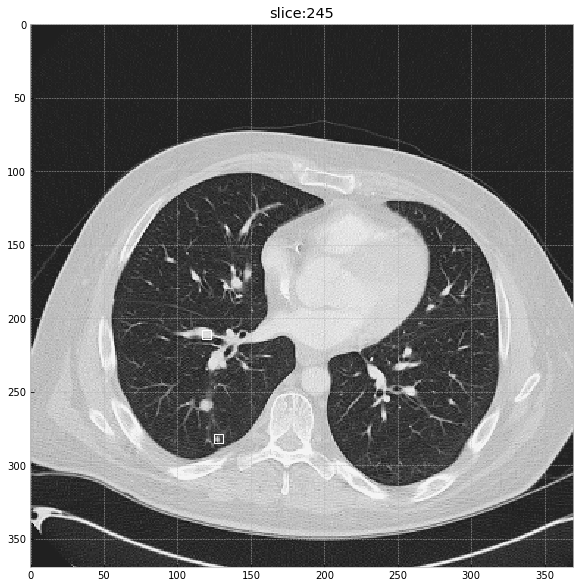

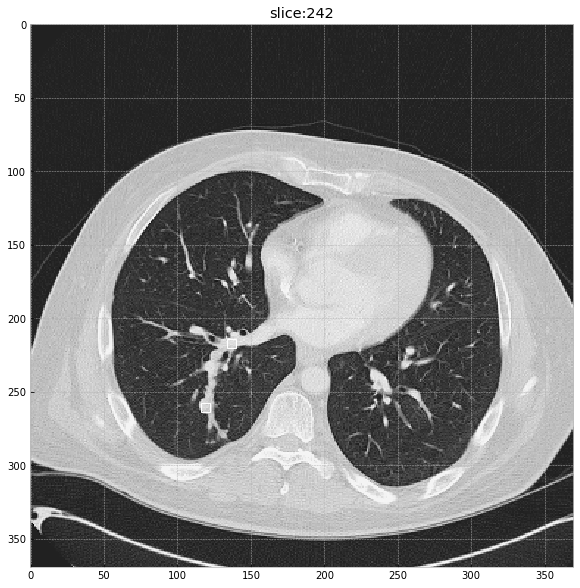

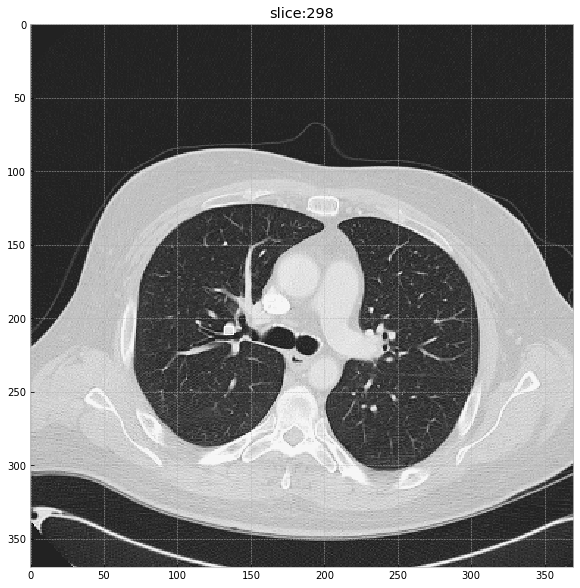

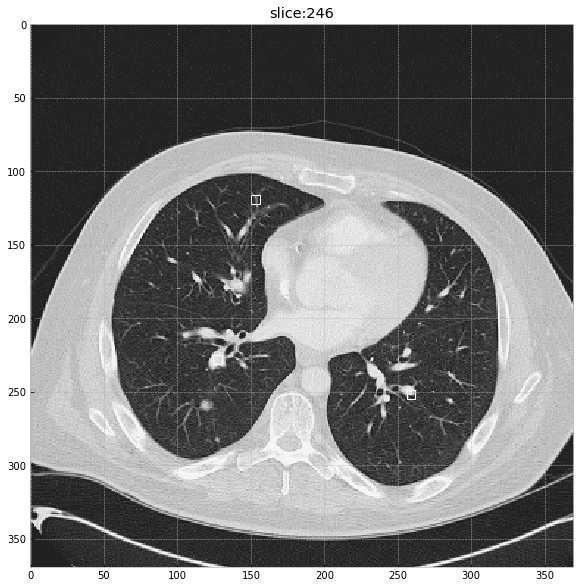

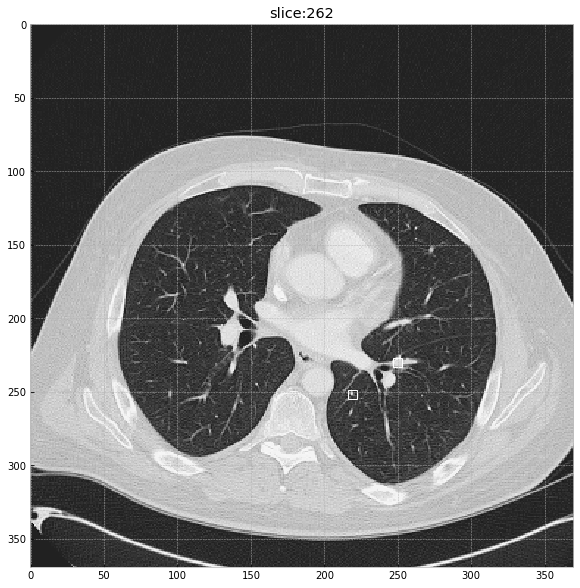

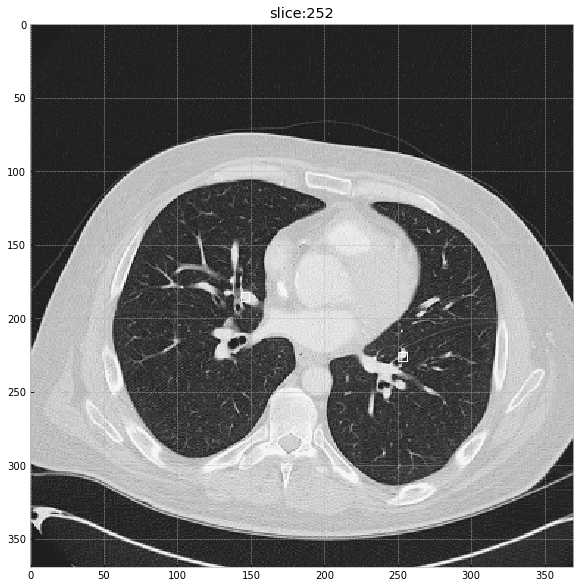

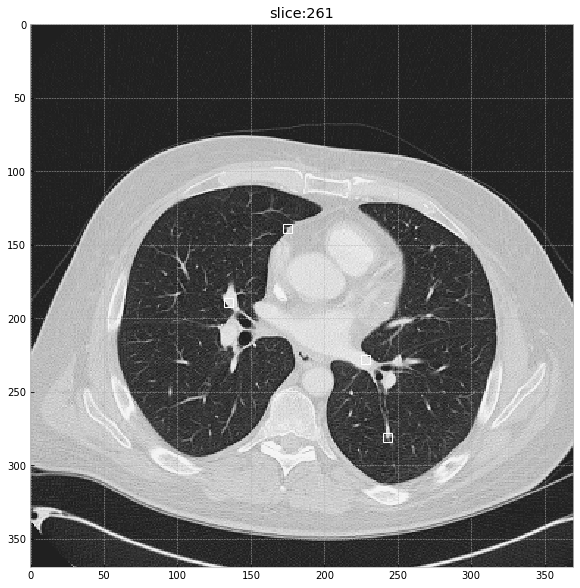

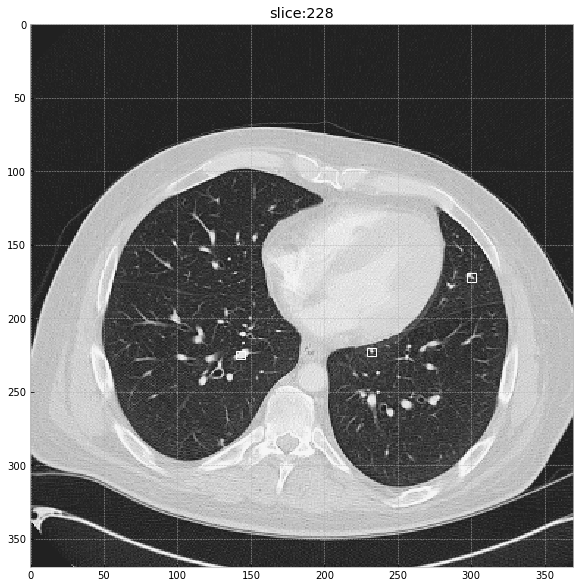

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [ ]:
plot_slices_w_nodules(patient_id, anno_df)

In [ ]:
patient_id = no_matches_df.iloc[0].patient_id

In [ ]:
print(get_nodules_by_patient_id(patient_id, no_matches_df))
# print(get_nodules_by_patient_id(patient_id, lidc_pos_df))
# print(get_nodules_by_patient_id(patient_id, luna_pos_df))